In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use("seaborn")

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize=(8,4))

# Prepare Dataset 

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

data_path = "../../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))
ind_val = int(0.8 * ind)

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)
s_train, p_train, s_val, p_val = split(s_train, p_train, ind_val)

In [6]:
s_train.shape, s_val.shape, s_test.shape

((640, 351), (160, 351), (201, 351))

# Test Utilities 

## Model generation 

In [7]:
dim_triu = dim * (dim + 1) // 2

In [10]:
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def build_model(activation, structure, learning_rate):



    model = keras.Sequential()

    
    # hidden
    for i, layer in enumerate(structure):

        if i == 0:
            # input layer + 1st hidden
            model.add(keras.layers.Dense(
                layer, 
                activation=activation, 
                input_dim=dim_triu, 
                kernel_initializer=intializer, 
                bias_initializer='zeros'
            ))        
        else:  
            model.add(keras.layers.Dense(
                    layer, 
                    activation=activation, 
                    kernel_initializer=intializer, 
                    #bias_initializer='zeros',
                    #kernel_regularizer=keras.regularizers.l2(1e-8)
            ))

            
    #output
    model.add(keras.layers.Dense(dim_triu))


    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])
    
    return model

## Training 

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=50, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    verbose=0, 
    mode='auto', 
    min_delta=1e-5, 
    cooldown=10, 
    min_lr=1e-10
)

In [16]:
n_tests = 5
n_resets = 3
epochs = 10000


def test_model(structure, activation, learning_rate=1e-4):
    error = []
    
    for i in range(n_tests):
        
        keras.backend.clear_session()
        model = build_model(activation, structure, learning_rate)
        
        for j in range(n_resets):
            keras.backend.set_value(model.optimizer.lr, learning_rate)
            
            history = model.fit(
                x = s_train,
                y = p_train,
                epochs=epochs,
                shuffle=True,
                validation_data=(s_val, p_val), 
                verbose=0, 
                callbacks=[
                    early_stopping, 
                    reduce_lr
                ]
            )
        
        error.append(model.evaluate(s_test, p_test, verbose=0)[1])
        
        print(" - Test " + str(i+1) + ": " + str(error[-1]))
    
    return error

def run_layer_test_series(activation, structures, learning_rate):
    error = []
    for structure in structures:
        print("Layers: " + str(structure))
        error.append(test_model(structure, activation, learning_rate=learning_rate))
    return error

# Testing 

In [17]:
structures = [
        [],
        [dim_triu],
        [dim_triu, dim_triu],
        [dim_triu, dim_triu, dim_triu],
        [dim_triu + 100, dim_triu + 100],
        [dim_triu + 250, dim_triu + 150, dim_triu + 50],
        [dim_triu + 100, dim_triu + 200, dim_triu + 100],
        [dim_triu, dim_triu, dim_triu, dim_triu, dim_triu]
    ]
        
learning_rates = [1e-3, 1e-4, 1e-5]

In [18]:
res = []
for lr in learning_rates:
    print("# lr" + str(lr))
    res.append(run_layer_test_series('elu', structures, lr))

# lr0.001
Layers: []
Epoch 00415: early stopping
Epoch 00243: early stopping
Epoch 00202: early stopping
 - Test 1: 0.007832465436198373
Epoch 00391: early stopping
Epoch 00240: early stopping
Epoch 00219: early stopping
 - Test 2: 0.007577393143738976
Epoch 00412: early stopping
Epoch 00230: early stopping
Epoch 00218: early stopping
 - Test 3: 0.007676882358888785
Epoch 00395: early stopping
Epoch 00255: early stopping
Epoch 00230: early stopping
 - Test 4: 0.007923295026394859
Epoch 00366: early stopping
Epoch 00234: early stopping
Epoch 00237: early stopping
 - Test 5: 0.007456712913583612
Layers: [351]
Epoch 00299: early stopping
Epoch 00247: early stopping
Epoch 00265: early stopping
 - Test 1: 0.004640556538282935
Epoch 00268: early stopping
Epoch 00254: early stopping
Epoch 00251: early stopping
 - Test 2: 0.00421135774257579
Epoch 00301: early stopping
Epoch 00255: early stopping
Epoch 00247: early stopping
 - Test 3: 0.0045571078022765875
Epoch 00297: early stopping
Epoch 002

Epoch 00268: early stopping
Epoch 00235: early stopping
 - Test 4: 0.005783713464416675
Epoch 00403: early stopping
Epoch 00261: early stopping
Epoch 00224: early stopping
 - Test 5: 0.005517326953325106
Layers: [451, 551, 451]
Epoch 00421: early stopping
Epoch 00241: early stopping
Epoch 00242: early stopping
 - Test 1: 0.005570458294592093
Epoch 00390: early stopping
Epoch 00267: early stopping
Epoch 00242: early stopping
 - Test 2: 0.005793420310637251
Epoch 00406: early stopping
Epoch 00265: early stopping
Epoch 00220: early stopping
 - Test 3: 0.005745478535061748
Epoch 00410: early stopping
Epoch 00282: early stopping
Epoch 00212: early stopping
 - Test 4: 0.005527898458421082
Epoch 00407: early stopping
Epoch 00281: early stopping
Epoch 00252: early stopping
 - Test 5: 0.005631708806445498
Layers: [351, 351, 351, 351, 351]
Epoch 00685: early stopping
Epoch 00236: early stopping
Epoch 00240: early stopping
 - Test 1: 0.006531566223917316
Epoch 00669: early stopping
Epoch 00269: e

In [19]:
x = [ 
    s for s in range(len(structures)) for i in range(n_tests)
]

In [20]:
np.save("data/hyperpar_res.npy", res)
np.save("data/hyperpar_x.npy", x)
np.save("data/hyperpar_structures.npy", structures)
np.save("data/hyperpar_lr.npy", learning_rates)


In [4]:
res = np.load("data/hyperpar_res.npy")
x = np.load("data/hyperpar_x.npy")
structures = np.load("data/hyperpar_structures.npy")
learning_rates = np.load("data/hyperpar_lr.npy")


In [13]:
def structure_string(structure):
    if structure:
        return "_".join(list(map(str,list(structure))))
    else:
        return "None"
structure_string(structures[1])

'351'

In [7]:
plt.rc("figure", figsize=(8,5))

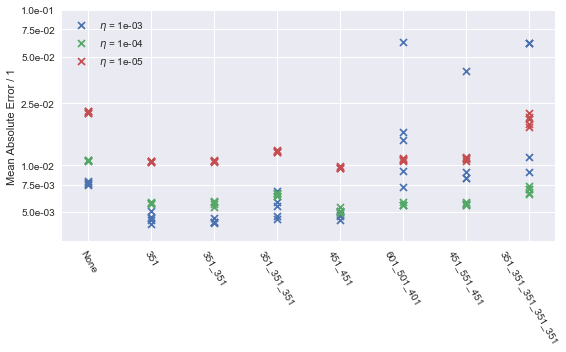

In [14]:
import matplotlib.ticker as mtick

fig = plt.figure()
ax = plt.gca()

for r, lr in zip(res, learning_rates):
    ax.scatter(x, np.array(r).flatten(), marker="x", label="$\eta$ = {:1.0e}".format(lr) )

ax.set_yscale('log')
#yticks = [2.5e-3, 5e-3, 7.5e-3, 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1]
yticks = [5e-3, 7.5e-3, 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1]
plt.yticks(yticks, yticks)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.1e'))

#plt.xlabel("Number of Hidden Layers / 1")
plt.ylabel("Mean Absolute Error / 1")

plt.xticks(
    np.arange(len(structures)),
    [structure_string(structure) for structure in structures],
    rotation=-60
)
#yticks = [2e-3, 5e-3, 1e-2, 5e-2, 1e-1]
#plt.yticks(yticks, yticks)

#plt.ylim(0.0025, 0.015)
plt.legend()
#plt.legend(loc='upper right',bbox_to_anchor=(1.15, 1.))
plt.tight_layout()

#plt.savefig("/home/jo/Repos/MastersThesis/SMatrixDescriptor/figures/HyperparameterStudy.pdf")

plt.show()

In [ ]:
(5e-3)**2